In [1]:
import os
import itertools
import importlib
import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import datetime as dt
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.patches as mpatches
from pdb import set_trace

from gfatpy.lidar.preprocessing import preprocess
from gfatpy.lidar.preprocessing.lidar_preprocessing import apply_dead_time_correction
from gfatpy.lidar.preprocessing.lidar_preprocessing_tools import preprocessing_photoncounting_signal
from gfatpy.lidar.preprocessing.gluing_proportional import gluing
from gfatpy.lidar.preprocessing.lidar_gluing_damico import gluing as gluing_damico
from gfatpy.utils.utils import residuals
from gfatpy.utils.optimized import windowed_corrcoefs
%matplotlib inline

In [2]:
data = r'C:\Users\Usuario\Documents\gitlab\gfatpy\tests\datos\ALHAMBRA\1a\2023\05\10\alh_1a_Prs_rs_xf_20230510.nc'
lidar = preprocess(data, apply_dt=False, save_bg=True, save_dc=True)

In [6]:
data = r'C:\Users\Usuario\Documents\gitlab\gfatpy\tests\datos\ALHAMBRA\1a\2023\05\08\alh_1a_Prs_rs_xf_20230508.nc'
raw = xr.open_dataset(data)

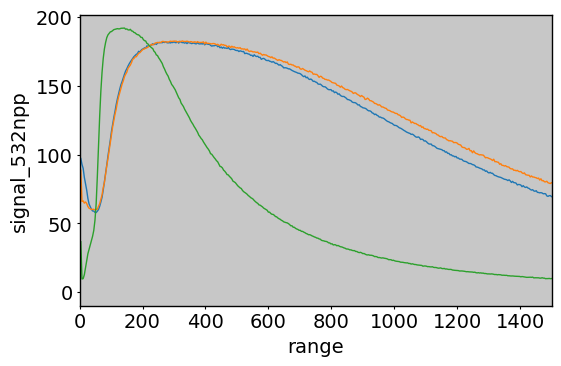

In [21]:
lidar.signal_355fpp.sel(time=slice('2023-05-10T00:32:36', '2023-05-10T01:00:00')).mean('time').plot()
lidar.signal_532ftp.sel(time=slice('2023-05-10T00:32:36', '2023-05-10T01:00:00')).mean('time').plot()
lidar.signal_532npp.sel(time=slice('2023-05-10T00:32:36', '2023-05-10T01:00:00')).mean('time').plot()
plt.xlim(0,1500)
plt.show()


In [4]:
#se crea un arreglo de fechas 
horas=[1]

for i in range(len(horas)):   #primer bucle que recorre la hora especificada cada 2 minutos
    inicio = dt.datetime(2023, 5, 10, horas[i], 0)
    fin= dt.datetime(2023, 5, 10, horas[i], 3)
    
    vars()['fechas_'+str(horas[i])]=[]

    while inicio <= fin:
        vars()['fechas_'+str(horas[i])].append(inicio)
        # Sumamos 2 minutos a la fecha de inicio
        inicio += dt.timedelta(minutes=1)
        
    #convertir el formato de la fecha 
    
    vars()['arreglo_fechas_'+str(horas[i])]=[]

    for fecha in vars()['fechas_'+str(horas[i])]:
        vars()['arreglo_fechas_'+str(horas[i])].append(fecha.strftime("%Y-%m-%dT%H:%M:%S.0"))
        
    ###################################################################################################################    

    #Set to default values
    tau_range = np.arange(2,6,0.5) # rangos establecido según código final_investigación
    gluing_range = (1500, 2500)

    #chanel = ('355','532','1064') bucle for para cada canal
    #for
    
    for i in range(len(horas)):  #para el arreglo de horas y durante el intervalo de min se determinan los best tau
        vars()['optimals_tau_'+str(horas[i])]=[]

        for j in range(len(vars()['arreglo_fechas_'+str(horas[i])])):

            dict_pc = {}
            residuos = {}
            signal_gl = {}
            residuo_gl = np.ones(len(tau_range))*np.nan
            corrected_r = np.ones(len(tau_range))*np.nan

            signal_an = lidar.signal_532fta.sel(time=slice(vars()['arreglo_fechas_'+str(horas[i])][j], vars()['arreglo_fechas_'+str(horas[i])][j+1]), range=slice(1000.,4000.)).mean('time')
            signal_pc = lidar.signal_532ftp.sel(time=slice(vars()['arreglo_fechas_'+str(horas[i])][j], vars()['arreglo_fechas_'+str(horas[i])][j+1]), range=slice(1000.,4000.)).mean('time')
            
#             fig,ax = plt.subplots()
#             signal_an.plot(label='an')
#             signal_pc.plot(label='pc')
#             ax.set_ylim(0,5)
#             ax.set_xlim(0,5000)
#             ax.legend()
            
            #Ajuste de datos
#             fig,ax = plt.subplots()
#             plt.scatter(signal_an.values,signal_pc.values)
#             set_trace()
            ranges = signal_an.range                       
            fit_values_raw = np.polyfit(signal_an, signal_pc,1)
             #Cálculo de residuos
            for idx_tau, tau_ in enumerate(tau_range):
                print(idx_tau, tau_)
                tau_us = tau_ * 1e-3
                dict_pc[tau_] = signal_pc / (1 - signal_pc * tau_us)
                corrected_r[idx_tau] = np.corrcoef(signal_an, dict_pc[tau_])[0,1]
                
                #Gluing coefficients
                fit_values_ = np.polyfit(signal_an, dict_pc[tau_],1)
                an2pc_ = np.polyval(fit_values_,signal_an)
                signal_gl_ = np.ones(len(ranges))*np.nan
                                
                signal_gl_[ranges<gluing_height] = an2pc_[ranges<gluing_height] 
                signal_gl_[ranges>gluing_height] = dict_pc[tau_][ranges>gluing_height]
                signal_gl[tau_] = signal_gl_
                residuo_gl[idx_tau] = residuals(dict_pc[tau_], signal_gl_)
            
            #Ajuste de datos
            fit2 = np.polyfit(tau_range, residuo_gl,4)


            #Cálculo optimal tau
            tau_range_fine = np.arange(2,6,0.01)
            k = np.polyval(fit2,tau_range_fine).argmin()
            vars()['optimals_tau_'+str(horas[i])].append(tau_range_fine[k])
            print('min poly=',np.min(np.polyval(fit2,tau_range_fine)), 'tau_range=',tau_range_fine[k]) #indica minimo del polinomio
            
#             for k in range(0, len(np.polyval(fit2,tau_range))):
#                 #optimals_tau[tau_range] = np.polyval(fit2,tau_range)
#                 if np.polyval(fit2,tau_range)[k]== min(np.polyval(fit2,tau_range)):
#                     vars()['optimals_tau_'+str(horas[i])].append(tau_range[k]) #guardar siempre los tau min sin borrar el anterior
#             print('min poly=',np.min(np.polyval(fit2,tau_range)), 'tau_range=',tau_range[k]) #indica minimo del polinomio             

#             fig,ax = plt.subplots()
#             ax.scatter(tau_range,residuo_gl)     
#             ax.plot(tau_range_fine, np.polyval(fit2,tau_range_fine))
#             title_str = vars()['arreglo_fechas_'+str(horas[i])][j].replace(':','').replace('-','').split('.')[0]
#             ax.set_title(f'{title_str}' + r' | $\tau_{optimal} [\mu s]$' + f' = {tau_range_fine[k]:.2f}')
#             ax.set_ylabel('Residuos')
#             ax.set_xlabel('$\tau, [\mu s]$')
# #             ax.set_ylim(0,5)
# #             ax.set_xlim(0,5000)
# #             ax.legend()
#             plt.savefig(f'residuos_{title_str}.png')
#             plt.close(fig)
#             set_trace()



0 2.0
1 2.5
2 3.0
3 3.5
4 4.0
5 4.5
6 5.0
7 5.5
min poly= 0.0008316018203050023 tau_range= 3.6999999999999638
0 2.0
1 2.5
2 3.0
3 3.5
4 4.0
5 4.5
6 5.0
7 5.5
min poly= 0.0009458550044549631 tau_range= 3.6999999999999638
0 2.0
1 2.5
2 3.0
3 3.5
4 4.0
5 4.5
6 5.0
7 5.5
min poly= 0.0009813383105843794 tau_range= 3.7199999999999633


IndexError: list index out of range

In [44]:
channel_an, channel_pc = '355fpa', '355fpp'
tau_range = np.arange(2,7,1) # rangos establecido según código final_investigación
tau_range_fine = np.arange(2,6,0.01)

time_range = ('20230510T01:00:00', '20230510T01:10:00')
gluing_range = (1000,2000)
gluing_height = np.mean(gluing_range)
slidar = lidar.sel(time=slice(*time_range))
ranges = slidar.range

matrix_pc = np.ones(len(ranges), len(tau_range))*np.nan
residuos = {}
signal_gl = {}
residuo_gl = np.ones(len(tau_range))*np.nan
corrected_r = np.ones(len(tau_range))*np.nan
optimals_taus = np.ones(len(slidar.time))*np.nan


for idx_time, time_ in enumerate(slidar.time):
    signal_an = slidar[f'signal_{channel_an}'].sel(time=time_)
    signal_pc = slidar[f'signal_{channel_pc}'].sel(time=time_)

    glue_signal_an = signal_an.sel(range=slice(*gluing_range))    
    
    #Cálculo de residuos
    for idx_tau, tau_ in enumerate(tau_range):        
        matrix_pc[idx_tau] = signal_pc / (1 - signal_pc * tau_ * 1e-3)
        glue_dict_pc_ = dict_pc[tau_].sel(range=slice(*gluing_range))        
        corrected_r[idx_tau] = np.corrcoef(glue_signal_an, glue_dict_pc_)[0,1]

        #Gluing coefficients        
        fit_values_ = np.polyfit(glue_signal_an, glue_dict_pc_,1)
        
        
        #Gluing signal merge
        an2pc_ = np.polyval(fit_values_,signal_an)
        signal_gl_ = np.ones(len(ranges))*np.nan
        signal_gl_[ranges<gluing_height] = an2pc_[ranges<gluing_height] 
        signal_gl_[ranges>gluing_height] = dict_pc[tau_][ranges>gluing_height]        
        residuo_gl[idx_tau] = residuals(dict_pc[tau_], signal_gl_)

        #Ajuste de datos
        fit2 = np.polyfit(tau_range, residuo_gl, 4)
        
        #Cálculo optimal tau
        found_tau_index = np.polyval(fit2,tau_range_fine).argmin()
        optimals_taus[idx_time] = tau_range_fine[found_tau_index]
    set_trace()

> c:\users\usuario\appdata\local\temp\ipykernel_24352\2623898978.py(19)<module>()

ipdb> optimals_taus
array([4.33,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
ipdb> q


In [ ]:
channel_an, channel_pc = '355fpa', '355fpp'
tau_range = np.arange(2,7,1) # rangos establecido según código final_investigación
tau_range_fine = np.arange(2,6,0.01)

time_range = ('20230510T01:00:00', '20230510T01:10:00')
gluing_range = (1000,2000)
gluing_height = np.mean(gluing_range)
slidar = lidar.sel(time=slice(*time_range))
ranges = slidar.range
times = slidar.time

matrix_pc = np.ones([len(times), len(ranges), len(tau_range)])*np.nan
residuos = {}
signal_gl = {}
residuo_gl = np.ones(len(tau_range))*np.nan
corrected_r = np.ones(len(tau_range))*np.nan
optimals_taus = np.ones(len(slidar.time))*np.nan

signal_an = slidar[f'signal_{channel_an}']
signal_pc = slidar[f'signal_{channel_pc}']

glue_signal_an = signal_an.sel(range=slice(*gluing_range))    
    

for idx_tau, tau_ in enumerate(tau_range):        
    matrix_pc[:,:,idx_tau] = (signal_pc / (1 - signal_pc * tau_ * 1e-3)).values


In [7]:
from gfatpy.utils.optimized import windowed_corrcoefs

In [15]:
time_range = ('20230510T01:00:00', '20230510T01:10:00')
slidar = lidar.sel(time=slice(*time_range))

an = slidar.signal_532fta.sel(range=slice(1000.,4000.)).values
pc = slidar.signal_532ftp.sel(range=slice(1000.,4000.)).values
r_array = windowed_corrcoefs(an, pc, int(1000/3.75))

In [ ]:
@njit
def correlate_vector_to_matrix(vector, matrix):
    """Correlate a vector to a matrix

    Args:
        vector (np.ndarray): Vector to correlate
        matrix (np.ndarray): Matrix to correlate

    Returns:
        np.ndarray: Correlation result
    """
    corr = np.zeros(matrix.shape[1])
    for i in range(matrix.shape[1]):
        corr[i] = np.corrcoef(vector, matrix[:, i])[0, 1]
    return corr

In [3]:
vars()['optimals_tau_'+str(horas[i])]

NameError: name 'horas' is not defined

In [11]:
residuo_gl

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16924\2753349750.py:7: RuntimeWarning: invalid value encountered in divide
  y = np.exp(-0.5 * ((x - media) / dst) ** 2) / (dst * np.sqrt(2 * np.pi))


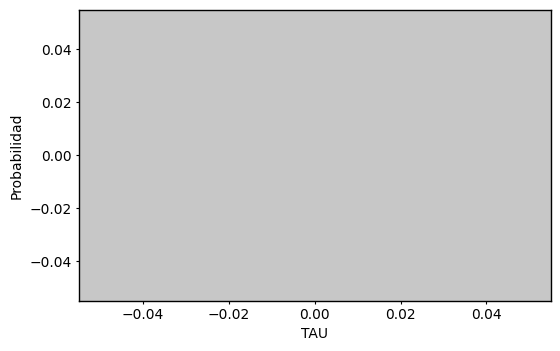

7.75
0.0


In [9]:
#Graficar optimals_tau 

data = vars()['optimals_tau_' + str(horas[i])]
media = np.mean(data)
dst = np.std(data)
x = np.linspace(min(data), max(data), 100)
y = np.exp(-0.5 * ((x - media) / dst) ** 2) / (dst * np.sqrt(2 * np.pi))

plt.plot(x, y, marker='p')
plt.xlabel('TAU')
plt.ylabel('Probabilidad')
plt.show()

print(media)
print(dst)

In [40]:
#Correct tau
tau = 6.15 # valor de tau que se utilizará para corregir la señal, pero que es residuo realmente
tau_us = tau  * 1e-3
corrected_signal_pc = signal_pc / (1 - signal_pc * tau_us)

#Gluing coefficients
fit_an = signal_an.sel(range=slice(gluing_height-gluing_window/2, gluing_height+gluing_window/2))
fit_pc = signal_pc.sel(range=slice(gluing_height-gluing_window/2, gluing_height+gluing_window/2))
fit_corrected_signal_pc = corrected_signal_pc.sel(range=slice(gluing_height-gluing_window/2, gluing_height+gluing_window/2))
#Fit antiguo (PC sin corregir de DT)
fit_values = np.polyfit(fit_an, fit_pc,1)
an2pc = np.polyval(fit_values,signal_an)
signal_gl = np.ones(len(ranges))*np.nan
signal_gl[ranges<1000] = an2pc[ranges<1000]   #señales menores a
signal_gl[ranges>1000] = signal_pc[ranges>1000] #señales mayores a

#Fit nuevo (PC sin corregir de DT)
corrected_fit_values = np.polyfit(fit_an, fit_corrected_signal_pc,1)
an2pc = np.polyval(corrected_fit_values, signal_an)
c_signal_gl = np.ones(len(ranges))*np.nan
c_signal_gl[ranges<1000] = an2pc[ranges<1000]   #señales menores a
c_signal_gl[ranges>1000] = corrected_signal_pc[ranges>1000] #señales mayores a

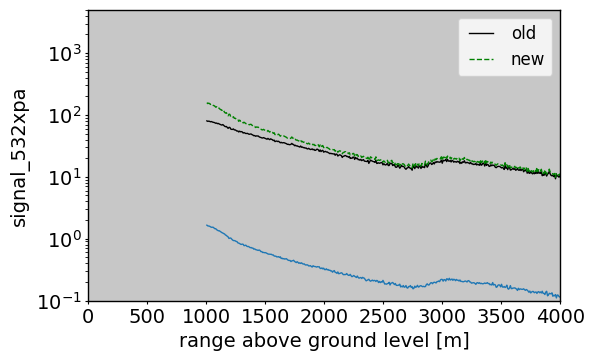

In [41]:
signal_an.plot()
plt.plot(ranges, signal_gl, c='k', label='old')
plt.plot(ranges, c_signal_gl, c='g', ls='--',label='new')
plt.ylim(0.1,5000)
plt.xlim(0,4000)
plt.yscale('log')
plt.legend()